# NYC Apartment Search

This project creates a Jupyter notebook to download, clean, and store data, as well as define a set of SQL queries and visualizations to help better search for apartments in New York City.The project is organized into 4 parts: data preprocessing, storing data, understanding data, and visualizing data.

The main datasets involved are NYC Open Data datasets [311 complaints](https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9) and [2015 tree census](https://data.cityofnewyork.us/Environment/2015-Street-Tree-Census-Tree-Data/pi5s-9p35), Zillow’s historic monthly rent averages rent from [here](https://drive.google.com/file/d/19h6qhJHjxyyNd4DML7pbf1pJGavQed0s/view), and NYC’s zip codes with geometric boundary data from [here](https://drive.google.com/drive/folders/1P89KAFAUAHVZsEcyDYVfD1L7pMeGBvIO).

# Setup

First of all, we import all necessary packages and set up file paths, database names, file names, etc., to ensure the project runs successfully.

In [7]:
# All import statements needed for the project
import json
import requests
import pandas as pd
import urllib.parse
import requests
import pathlib
from pathlib import Path
import psycopg2
import geoalchemy2 as gdb
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import shapely
import sqlalchemy as db
import matplotlib as mpl
import matplotlib.pyplot as plt
from shapely.geometry import Point
import matplotlib.animation as animation
import unittest
import contextily as ctx
import matplotlib.animation as animation
from IPython.display import HTML
from sqlalchemy.orm import declarative_base

In [8]:
# All constants needed for the project
ZIPCODE_DATA_FILE = 'data/zipcodes/nyc_zipcodes.shp'
RENT_DATA_FILE = 'data/zillow_rent_data.csv'

NYC_DATA_APP_TOKEN = "qusZQnQU0ua9VbjGpXFDVhsbK"
BASE_NYC_DATA_URL = "https://data.cityofnewyork.us/"
NYC_DATA_311 = "erm2-nwe9.geojson"
NYC_DATA_TREES = "5rq2-4hqu.geojson"

DB_NAME = "FINAL_PROJECT_DATA"
DB_USER = "leticialx"
DB_URL = f"postgresql+psycopg2://{DB_USER}@localhost/{DB_NAME}"
DB_SCHEMA_FILE = "schema.sql"

# Directory where DB queries for Part 3 will be saved
QUERY_DIR = pathlib.Path("queries")

In [9]:
# Make sure the QUERY_DIRECTORY exists
if not QUERY_DIR.exists():
    QUERY_DIR.mkdir()

# Part 1: Data Preprocessing

In this part, we preprocess datasets that will be needed to answer questions in the following parts. For the zip code data and Zillow data, we manually download the data from the links above and save it to a directory called data. For the 311 and tree data, we programmatically download the datasets from the NYC Open Data Account we set up earlier. 

We use the pandas and geopandas packages to load and clean all the datasets. The process of cleaning & filtering the data include: removing unnecessary columns, remove invalid data points, normalize column names & column types where needed, normalize the Spatial Reference Identifiers (SRID) of any geometry. The general information about datasets are as follows:

- `311 complaints data`: 
    - 4 columns: 'created_date', 'complaint_type',
                 'incident_zip', 'geometry'
    - 34 968 353 rows 
- `tree data`:
    - 6 columns: 'tree_id', 'zipcode', 'spc_common'
                 'health', 'status', 'geometry'
    - 683 787 rows
- `NYC zipcodes data`:
    - 2 columns: 'zipcode', 'geometry'
    - 263 rows
- `Zillow's rent data`:
    - 3 columns: 'rent_zip', 'rent_date', 'ret_amount'
    - 705 809 rows

In [4]:
def download_nyc_geojson_data(url: str,
                              file_name: str, 
                              force: bool = False) -> gpd.GeoDataFrame:
    """
    Download NYC GeoJSON data from a provided URL and saves it to a file.
    
    Keyword arguments:
    url (str) -- the URL from which the GeoJSON data will be downloaded
    file_name (str) -- the name of the file (without extension) to save the GeoJSON data
    force (bool, optional) -- if True, forces re-download of the file even if it exists locally (default is false)
    """
    
    filename = Path(file_name + '.geojson')
    
    if force or not filename.exists():
        print(f"Downloading {url} to {file_name}...")
    
        response = requests.get(url)
        text = response.text

        with open(file_name + '.geojson', 'w') as file:
            file.write(text)
        print(f"Done downloading {url}.")
        
    else:
        print(f"Reading from {file_name}...")
    
    gdf = gpd.read_file(file_name + '.geojson', driver = 'GeoJSON')
    return gdf

In [5]:
def download_and_clean_311_data() -> gpd.GeoDataFrame:
    """Download and clean 311 complaints data."""
    
    url = "https://data.cityofnewyork.us/resource/erm2-nwe9.geojson?$$app_token=RbFfvU4T8a7C7rDHaA9eqAkvZ&$40000000"
    
    file_name = 'complaints'
    complaints = download_nyc_geojson_data(url, file_name, force=False)
    
    # choose the columns we need
    new_complaints = complaints[['created_date', 'incident_zip', 'complaint_type', 'geometry']]
    
    # normalize SRID to EPSG:4326
    new_complaints = new_complaints.to_crs(epsg=4326)
    
    # delete NaN
    columns_with_nan = new_complaints.columns[new_complaints.isnull().any()].tolist()
    
    for column_name in columns_with_nan:
        print("Processing column:", column_name)
        new_complaints = new_complaints.dropna(subset=[column_name])
        print("Removed rows with NaN value in", column_name)

    return new_complaints

In [6]:
def download_and_clean_tree_data() -> gpd.GeoDataFrame:
    """Download and clean 2015 tree census data."""
    
    url = "https://data.cityofnewyork.us/resource/5rq2-4hqu.geojson?$$app_token=RbFfvU4T8a7C7rDHaA9eqAkvZ&$40000000"
    file_name = 'trees'
    trees = download_nyc_geojson_data(url, file_name, force=False)
    
    # normalize SRID to EPSG:4326
    trees = trees.to_crs(epsg=4326)
    
    # delete NaN
    columns_with_nan = trees.columns[trees.isnull().any()].tolist()
    
    for column_name in columns_with_nan:
        print("Processing column:", column_name)
        trees = trees.dropna(subset=[column_name])
        print("Removed rows with NaN value in", column_name)
        
    # choose the columns we need
    new_trees = trees[['tree_id', 'zipcode', 'spc_common', 'health', 'status','geometry']].copy()

    return new_trees

In [13]:
def load_and_clean_zipcodes(zipcode_datafile: str) -> gpd.GeoDataFrame:
    """Load and clean NYC’s zip codes with geometric boundary data data."""
    
    zipcode_data = gpd.read_file(zipcode_datafile)
    
    zipcodes = zipcode_data[['ZIPCODE', 'geometry']]
    zipcodes = zipcodes.rename(columns={'ZIPCODE': 'zipcode'})
    
    # normalize SRID to EPSG:4326
    zipcodes = zipcodes.to_crs(epsg=4326)
    
    return zipcodes

In [14]:
def load_and_clean_zillow_data(rent_datafile: str) -> pd.DataFrame:
    """Load and clean historical monthly average rents by zip code from Zillow."""
    
    zillow_rent_data = pd.read_csv(rent_datafile)
    
    columns_to_drop = ['RegionID', 'SizeRank', 'RegionType', 'State', 'StateName', 'City', 'Metro', 'CountyName']
    df_zillow_data = zillow_rent_data.drop(columns=columns_to_drop)
    
    # normalize rent data
    df_zillow_data = df_zillow_data.rename(columns={'RegionName': 'rent_zip'})

    rents = pd.melt(df_zillow_data, id_vars=['rent_zip'], var_name='rent_date', value_name='rent_amount')
    # set datetime type
    rents['rent_date'] = pd.to_datetime(rents['rent_date'])
    
    # drop NaNs
    rents = rents.dropna()
    
    return rents

In [15]:
def load_all_data() -> (gpd.GeoDataFrame, gpd.GeoDataFrame, gpd.GeoDataFrame, pd.DataFrame):
    """Load all data."""
    geodf_zipcode_data = load_and_clean_zipcodes(ZIPCODE_DATA_FILE)
    df_zillow_data = load_and_clean_zillow_data(RENT_DATA_FILE)
    return (
        geodf_zipcode_data,
        df_zillow_data
    )

In [ ]:
def load_all_data() -> (gpd.GeoDataFrame, gpd.GeoDataFrame, gpd.GeoDataFrame, pd.DataFrame):
    """Load all data."""
    geodf_zipcode_data = load_and_clean_zipcodes(ZIPCODE_DATA_FILE)
    geodf_311_data = download_and_clean_311_data()
    geodf_tree_data = download_and_clean_tree_data()
    df_zillow_data = load_and_clean_zillow_data(RENT_DATA_FILE)
    return (
        geodf_zipcode_data,
        geodf_311_data,
        geodf_tree_data,
        df_zillow_data
    )

In [16]:
geodf_zipcode_data, df_zillow_data = load_all_data()

In [ ]:
geodf_zipcode_data, geodf_311_data, geodf_tree_data, df_zillow_data = load_all_data()

In [17]:
# Show basic info about each dataframe
geodf_zipcode_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   zipcode   263 non-null    object  
 1   geometry  263 non-null    geometry
dtypes: geometry(1), object(1)
memory usage: 4.2+ KB


In [18]:
# Show first 5 entries about each dataframe
geodf_zipcode_data.head()

zipcode                                           geometry
0   11436  POLYGON ((-73.80585 40.68291, -73.80569 40.682...
1   11213  POLYGON ((-73.93740 40.67973, -73.93487 40.679...
2   11212  POLYGON ((-73.90294 40.67084, -73.90223 40.668...
3   11225  POLYGON ((-73.95797 40.67066, -73.95576 40.670...
4   11218  POLYGON ((-73.97208 40.65060, -73.97192 40.650...

In [32]:
geodf_311_data['incident_zip'] = geodf_311_data['incident_zip'].astype(float).astype('Int64').astype(str)

In [33]:
geodf_311_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 34968354 entries, 0 to 34968353
Data columns (total 4 columns):
 #   Column          Dtype         
---  ------          -----         
 0   created_date    datetime64[ns]
 1   complaint_type  object        
 2   incident_zip    object        
 3   geometry        geometry      
dtypes: datetime64[ns](1), geometry(1), object(2)
memory usage: 1.0+ GB


In [34]:
geodf_311_data.head()

created_date       complaint_type incident_zip  \
0 2020-06-24 11:56:52    Abandoned Vehicle        11377   
1 2020-06-28 01:41:04  Noise - Residential        11207   
2 2020-06-29 00:12:51    Illegal Fireworks        11423   
3 2020-06-21 20:41:00  Noise - Residential        11221   
4 2020-06-25 01:46:39    Illegal Fireworks        11216   

                     geometry  
0  POINT (-73.89207 40.74056)  
1  POINT (-73.87824 40.65920)  
2  POINT (-73.76501 40.71329)  
3  POINT (-73.91622 40.69666)  
4  POINT (-73.94790 40.67756)

In [21]:
geodf_tree_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 652118 entries, 0 to 683787
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   tree_id     652118 non-null  object  
 1   zipcode     652118 non-null  object  
 2   spc_common  652118 non-null  object  
 3   health      652118 non-null  object  
 4   status      652118 non-null  object  
 5   geometry    652118 non-null  geometry
dtypes: geometry(1), object(5)
memory usage: 34.8+ MB


In [22]:
geodf_tree_data.head()

tree_id zipcode       spc_common health status                    geometry
0  180683   11375        red maple   Fair  Alive  POINT (-73.84422 40.72309)
1  200540   11357          pin oak   Fair  Alive  POINT (-73.81868 40.79411)
2  204026   11211      honeylocust   Good  Alive  POINT (-73.93661 40.71758)
3  204337   11211      honeylocust   Good  Alive  POINT (-73.93446 40.71354)
4  189565   11215  American linden   Good  Alive  POINT (-73.97598 40.66678)

In [23]:
df_zillow_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250167 entries, 0 to 705809
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   rent_zip     250167 non-null  int64         
 1   rent_date    250167 non-null  datetime64[ns]
 2   rent_amount  250167 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 7.6 MB


In [24]:
df_zillow_data.head()

rent_zip  rent_date  rent_amount
0      77494 2015-01-31  1606.206406
1      77449 2015-01-31  1257.814660
5      78660 2015-01-31  1399.372678
8      77433 2015-01-31  1332.384333
11     37013 2015-01-31  1139.424798

### Data for extra credit 4

Programmatically download the `Film Permit` dataset from the NYC Open Data Account we set up earlier. 

In [133]:
def download_csv_from_url(url: str, save_path: str):
    response = requests.get(url)
    if response.status_code == 200:
        with open(save_path, 'wb') as file:
            file.write(response.content)
        print(f"CSV data downloaded successfully from {url} and saved to {save_path}")
    else:
        print(f"Failed to download CSV data from {url}. Status code: {response.status_code}")

In [26]:
# Download and read data
csv_url = 'https://data.cityofnewyork.us/resource/tg4x-b46p.csv?$$app_token=RbFfvU4T8a7C7rDHaA9eqAkvZ&$limit=4000'
file_path_to_save = 'data/film_permits.csv'

download_csv_from_url(csv_url, file_path_to_save)
film_permits_data = pd.read_csv('data/film_permits.csv')

CSV data downloaded successfully from https://data.cityofnewyork.us/resource/tg4x-b46p.csv?$$app_token=RbFfvU4T8a7C7rDHaA9eqAkvZ&$limit=4000 and saved to data/film_permits.csv


In [39]:
# Select and normalize relevant columns
film_permits_data['startdatetime'] = pd.to_datetime(film_permits_data['startdatetime'])
film_permits_data['enddatetime'] = pd.to_datetime(film_permits_data['enddatetime'])

df_film_permits = film_permits_data[['startdatetime', 'enddatetime', 'eventtype', 'zipcode_s']]
df_film_permits.columns = ['start_date', 'end_date', 'event_type', 'zipcode_s']

In [40]:
df_film_permits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3508 entries, 0 to 3507
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   start_date  3508 non-null   datetime64[ns]
 1   end_date    3508 non-null   datetime64[ns]
 2   event_type  3508 non-null   object        
 3   zipcode_s   3506 non-null   object        
dtypes: datetime64[ns](2), object(2)
memory usage: 109.8+ KB


# Part 2: Storing Data

We created a `schema.sql` which defined each table's schema. Used the datasets we downloaded & cleaned from Part 1, and created & populated a PostgreSQL database `FINAL_PROJECT_DATA` with 5 tables (including tables for extra credit question) generated from the datasets.

In [35]:
# Our database
engine = db.create_engine(DB_URL)

In [36]:
# Define the SQL statements to create 4 tables using SQL
ZIPCODE_SCHEMA = """
CREATE TABLE nyc_zip_codes (
    id SERIAL PRIMARY KEY,
    zip_code INTEGER,
    geom POLYGON
)
"""

NYC_311_SCHEMA = """
CREATE TABLE complaints_311 (
    id SERIAL PRIMARY KEY,
    created_date TIMESTAMP,
    complaints_type TEXT,
    incident_zip INTEGER,
    geometry POINT
)
"""

NYC_TREE_SCHEMA = """
CREATE TABLE trees (
    id SERIAL PRIMARY KEY,
    tree_id INTEGER,
    tree_zip INTEGER,
    spc_common TEXT,
    health TEXT,
    status TEXT,
    geometry POINT
)
"""

ZILLOW_SCHEMA = """
CREATE TABLE rents (
    id SERIAL PRIMARY KEY,
    rent_zip INTEGER,
    rent_date DATE,
    rent NUMERIC(6)
)
""" 

FILM_SCHEMA = """
CREATE TABLE permits (
    id SERIAL PRIMARY KEY,
    startdatetime TIMESTAMP,
    enddatetime TIMESTAMP,
    eventtype TEXT,
    zipcodes TEXT
)
"""

In [37]:
# Create that required schema.sql file
with open(DB_SCHEMA_FILE, "w") as f:
    f.write(ZIPCODE_SCHEMA)
    f.write(NYC_311_SCHEMA)
    f.write(NYC_TREE_SCHEMA)
    f.write(ZILLOW_SCHEMA)
    # Extra credit 4
    f.write(FILM_SCHEMA)

In [43]:
# Execute the schema files to create tables using SQL
with engine.connect() as connection:
    
    connection.execute("DROP TABLE IF EXISTS nyc_zip_codes, complaints_311, trees, rents, permits CASCADE") # if table already exists
    
    connection.execute(ZIPCODE_SCHEMA)
    connection.execute(NYC_311_SCHEMA)
    connection.execute(NYC_TREE_SCHEMA)
    connection.execute(ZILLOW_SCHEMA)
    # Extra credit 4
    connection.execute(FILM_SCHEMA)

### Add Data to Database

In [45]:
# Dataframe to sql table
df_zillow_data.to_sql('rents', con=engine, if_exists='replace', index=False)

# GeoDataFrame data into a PostGIS-enabled PostgreSQL table
geodf_311_data.to_postgis('complaints', con=engine, if_exists='replace', index=False)
geodf_zipcode_data.to_postgis('zipcodes', con=engine, if_exists='replace', index=False)
geodf_tree_data.to_postgis('trees', con=engine, if_exists='replace', index=False)

/Users/leticialx/anaconda3/lib/python3.11/site-packages/pandas/io/sql.py:1781: SAWarning: Did not recognize type 'point' of column 'geometry'
  self.meta.reflect(bind=self.connectable, only=[table_name], schema=schema)


In [46]:
# Extra credit 4
df_film_permits.to_sql('permits', con=engine, if_exists='replace', index=False)

508

# Part 3: Understanding the Data

In [47]:
# Helper function to write the queries to file
def write_query_to_file(query: str, outfile: str):
    with open(outfile, "w") as f:
        f.write(query)

## Query 1: Which area might be more calm to live in?

Areas whose zip codes are 11581, 11443, 11431, etc. might be more calm to live in because, in the past several months, there was only one complaint per area from those areas' residents. 

On the contrary, area 11226 might be the noisiest place to live in because there were over 60k complaints from area residents in the past year.

In [48]:
QUERY_1_FILENAME = QUERY_DIR / "num_complaints_by_zipcode"

QUERY_1 = """
SELECT incident_zip, COUNT(*) AS complaints_count
FROM complaints
WHERE
    created_date BETWEEN '2022-10-01' AND '2023-12-30'
GROUP BY incident_zip
ORDER BY complaints_count DESC
"""

In [49]:
write_query_to_file(QUERY_1, QUERY_1_FILENAME)

In [50]:
# Execute the query
with engine.connect() as connection:
    result = connection.execute(QUERY_1)

for row in result:
    print(row)

('11226', 60407)
('10467', 57438)
('10468', 54093)
('10452', 52446)
('11385', 52002)
('10457', 50792)
('10458', 49859)
('11201', 49741)
('10456', 48872)
('11207', 48492)
('<NA>', 47948)
('10453', 45290)
('11208', 44243)
('10031', 40640)
('11221', 40281)
('10025', 39120)
('10032', 39010)
('10466', 38328)
('10462', 37673)
('11238', 37006)
('11368', 36148)
('11230', 36018)
('10019', 34902)
('11220', 34870)
('11225', 34325)
('11216', 33810)
('11235', 33457)
('11212', 33358)
('10463', 33039)
('10460', 32768)
('11203', 32376)
('11214', 32228)
('11215', 32174)
('11377', 32003)
('10027', 31978)
('11213', 31804)
('10023', 31635)
('11101', 31337)
('11211', 31264)
('10002', 31253)
('11209', 31076)
('11233', 30864)
('11206', 30790)
('11222', 30765)
('10472', 30439)
('11218', 30433)
('11373', 30362)
('11234', 30192)
('11223', 29976)
('10003', 28798)
('10033', 28681)
('11229', 28369)
('11237', 28316)
('10034', 27368)
('11236', 27221)
('10011', 26604)
('10461', 26604)
('11204', 26175)
('10026', 26153

## Query 2: Where has the most greenery?

The area with zipcode 10312 has the most greenery. There are more than 21 thousand trees in this area.

The top 10 greenest areas are (10312, 10314, 10306, 10309, 11234, 11385, 11357, 11207, 11208, 11434). Analyzing these zipcodes, we can see that areas with more trees are often closer to each other. 

In [51]:
QUERY_2_FILENAME = QUERY_DIR / "top_10_zipcodes_with_most_trees"

QUERY_2 = """
SELECT zipcode, COUNT(*) AS total_trees
FROM trees
GROUP BY zipcode
ORDER BY total_trees DESC
LIMIT 10;
"""

In [52]:
QUERY_2 = """
SELECT *
FROM trees
LIMIT5
"""

In [53]:
write_query_to_file(QUERY_2, QUERY_2_FILENAME)

In [132]:
# Execute the query
with engine.connect() as connection:
    result = connection.execute(QUERY_2)

for row in result:
    print(row)

('10312', 21356)
('10314', 16330)
('10306', 12616)
('10309', 12105)
('11234', 10838)
('11385', 10262)
('11357', 9016)
('11207', 8294)
('11208', 7896)
('11434', 7833)


## Query 3: Can I afford a place in the areas with the most trees?

If you can afford to rent for at least $1775.09, then you can live in the top 10 greenest areas.

Among the top 10 greenest areas, an area with zipcode 10312, which has the most greenery, has the lowest rent price, $1775.09. 

Average rents for most of these areas are more than $2000.

The most expensive place in these 10 areas is 11207, whose average rent is $3079.09. 

In [55]:
QUERY_3_FILENAME = QUERY_DIR / "avg_rent_for_top_10_zipcodes_with_most_trees"

QUERY_3 = """
WITH top10_zipcodes AS (
    SELECT zipcode, COUNT(*) AS total_trees
    FROM trees
    GROUP BY zipcode
    ORDER BY total_trees DESC
    LIMIT 10
)

SELECT t.zipcode, ROUND(r.rent_amount::numeric, 2)
FROM rents r
JOIN top10_zipcodes t ON t.zipcode = r.rent_zip::text
WHERE DATE_PART('month', r.rent_date) = 8
    AND DATE_PART('year', r.rent_date) = 2023
ORDER BY (SELECT total_trees FROM top10_zipcodes WHERE zipcode = t.zipcode) DESC;
"""

In [56]:
write_query_to_file(QUERY_3, QUERY_3_FILENAME)

In [57]:
# Execute the query
with engine.connect() as connection:
    result = connection.execute(QUERY_3)

for row in result:
    print(row)

('10312', Decimal('1775.09'))
('10314', Decimal('2465.47'))
('10306', Decimal('2331.54'))
('10309', Decimal('1832.01'))
('11234', Decimal('2312.31'))
('11385', Decimal('3064.48'))
('11357', Decimal('2458.81'))
('11207', Decimal('3079.09'))
('11208', Decimal('2737.55'))
('11434', Decimal('2645.92'))


## Query 4: Could there be a correlation between an area’s rent, the number of its trees, and the number of 311 complaints?

According to our output, there might be some positive relationship between an area's rent and the number of trees and a negative relationship between an area's rent and the number of 311 complaints. It is obvious that people are willing to pay more money for greener places and less money for places that have a lot of complaints.

But some areas which have the most greenery also have relatively many complaints like 11207, 11208. This might be because more people live in those areas so there are more complaints.

In [61]:
QUERY_4_FILENAME = QUERY_DIR / "rent_trees_complaints_correlation"

QUERY_4 = """
WITH RentData AS (
    SELECT CAST(r.rent_zip AS TEXT) AS zipcode, 
           CAST(AVG(r.rent_amount) AS DECIMAL(10, 2)) AS average_rent
    FROM rents r
    WHERE DATE_PART('month', r.rent_date) = 1
      AND DATE_PART('year', r.rent_date) = 2023
    GROUP BY r.rent_zip
),
TreeData AS (
    SELECT zipcode, COUNT(*) AS tree_count
    FROM trees
    GROUP BY zipcode
),
ComplaintData AS (
    SELECT incident_zip AS zipcode, COUNT(*) AS complaint_count
    FROM complaints
    WHERE DATE_PART('month', created_date) = 1
      AND DATE_PART('year', created_date) = 2023
    GROUP BY incident_zip
),
LowestRent AS (
    SELECT * FROM RentData
    ORDER BY average_rent ASC
    LIMIT 5
),
HighestRent AS (
    SELECT * FROM RentData
    ORDER BY average_rent DESC
    LIMIT 5
)
SELECT lr.zipcode,
       lr.average_rent AS formatted_rent,
       COALESCE(td.tree_count, 0) AS tree_count,
       COALESCE(cd.complaint_count, 0) AS complaint_count
FROM LowestRent lr
LEFT JOIN TreeData td ON lr.zipcode = td.zipcode
LEFT JOIN ComplaintData cd ON lr.zipcode = cd.zipcode
UNION ALL
SELECT hr.zipcode,
       hr.average_rent AS formatted_rent,
       COALESCE(td.tree_count, 0) AS tree_count,
       COALESCE(cd.complaint_count, 0) AS complaint_count
FROM HighestRent hr
LEFT JOIN TreeData td ON hr.zipcode = td.zipcode
LEFT JOIN ComplaintData cd ON hr.zipcode = cd.zipcode;
"""

In [62]:
write_query_to_file(QUERY_4, QUERY_4_FILENAME)

In [63]:
# Execute the query
with engine.connect() as connection:
    result = connection.execute(QUERY_4)

for row in result:
    print(row)

('50702', Decimal('723.07'), 0, 0)
('48503', Decimal('701.58'), 0, 0)
('72114', Decimal('723.04'), 0, 0)
('67501', Decimal('631.74'), 0, 0)
('61832', Decimal('648.49'), 0, 0)
('11954', Decimal('23662.30'), 0, 0)
('11963', Decimal('41561.34'), 0, 0)
('11937', Decimal('32893.57'), 0, 0)
('11968', Decimal('38626.57'), 0, 0)
('81611', Decimal('33056.44'), 0, 0)


## Query 5: Where has the most greenery (take 2)?

Without using the column named 'zipcode', we try to use column 'geometry', to find the zipcode of each tree location by point coordinates.

The output of QUERY_5 is the same as the output fo QUERY_2.

In [64]:
QUERY_5_FILENAME = QUERY_DIR / "top_10_zipcodes_with_most_trees_by_geometry"

QUERY_5 = """
SELECT z.zipcode, COUNT(*) AS total_trees
FROM zipcodes z
JOIN trees AS t ON ST_Contains(z.geometry, t.geometry)
GROUP BY z.zipcode
ORDER BY total_trees DESC
LIMIT 10;
"""

In [65]:
write_query_to_file(QUERY_5, QUERY_5_FILENAME)

In [66]:
# Execute the query
with engine.connect() as connection:
    result = connection.execute(QUERY_5)

for row in result:
    print(row)

('10312', 21356)
('10314', 16330)
('10306', 12616)
('10309', 12105)
('11234', 10838)
('11385', 10262)
('11357', 9016)
('11207', 8294)
('11208', 7896)
('11434', 7833)


## Query 6: What is the immediate area like?

There are many trees located within ½ mile radius of point `(40.80737875669467, -73.96253174434912)`, such as 'pin oak', 'London planetree', willow oak', 'American elm', etc.

In [67]:
target_latitude = 40.80737875669467
target_longitude = -73.96253174434912

target_point = Point(target_longitude, target_latitude)

# Create a circle with a radius of 0.5 miles around the target location
radius = 0.5  # In miles
circle_buffer = target_point.buffer(radius / 69)  # Assuming 1 degree of latitude is approximately 69 miles

gdf_circle = gpd.GeoDataFrame(geometry=[circle_buffer])

In [68]:
QUERY_6_FILENAME = QUERY_DIR / "trees_within_coordinate_pair"

QUERY_6 = f"""
SELECT tree_id, spc_common, health, status, ST_AsText(geometry) AS coordinate_location
FROM trees
WHERE ST_Intersects(geometry, ST_GeomFromText('{circle_buffer.wkt}', 4326))
"""

In [69]:
write_query_to_file(QUERY_6, QUERY_6_FILENAME)

In [70]:
# Execute the query
with engine.connect() as connection:
    result = connection.execute(QUERY_6)

for row in result:
    print(row)

('198514', 'pin oak', 'Good', 'Alive', 'POINT(-73.96207980385901 40.80230108588602)')
('209919', 'London planetree', 'Good', 'Alive', 'POINT(-73.96331506361766 40.808811547267055)')
('209921', 'London planetree', 'Good', 'Alive', 'POINT(-73.96340334087577 40.80874458097537)')
('203887', 'willow oak', 'Good', 'Alive', 'POINT(-73.96071917063361 40.805725833688264)')
('196440', 'American elm', 'Fair', 'Alive', 'POINT(-73.96412322243684 40.81114537770991)')
('209913', 'pin oak', 'Good', 'Alive', 'POINT(-73.96312071522566 40.809077091635245)')
('178550', 'Norway maple', 'Good', 'Alive', 'POINT(-73.95739876534434 40.806903447365045)')
('189403', 'Callery pear', 'Fair', 'Alive', 'POINT(-73.95861205918303 40.80754134482308)')
('196606', 'honeylocust', 'Good', 'Alive', 'POINT(-73.96719943972623 40.80732246649563)')
('198512', 'pin oak', 'Good', 'Alive', 'POINT(-73.96230576828576 40.8023961095017)')
('196541', 'honeylocust', 'Good', 'Alive', 'POINT(-73.96549830227003 40.80929314213609)')
('20399

# Part 4: Visualizing Data

In this part, we create a bunch of visualizations to enhance our understanding of the datasets, as well as gain better insights on NYC apartment research. Before using pandas and geopandas to help parse data to generate a visualization, we write queries to read the data from our PostgreSQL database. We make use of both DataFrame and GeoDataFrame (stores geometry information).

In [71]:
# Render graphics directly in the notebook without having to call plt.show
%matplotlib inline
plt.style.use("seaborn-dark")  # Choose a color palett

/var/folders/x1/12cg6y756v1bg3krkyfd6whc0000gn/T/ipykernel_60011/534305541.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-dark")  # Choose a color palett


In [72]:
# Query to select data
query1 = 'SELECT * FROM rents'
query2 = 'SELECT * FROM complaints'
query3 = 'SELECT * FROM trees'
query4 = 'SELECT * FROM zipcodes'

In [73]:
# Read all data into pandas DataFrame and geopandas GeoDataFrame
rent_data = pd.read_sql(query1, engine)

complaint_data = gpd.read_postgis(query2, con=engine, geom_col='geometry')
tree_data = gpd.read_postgis(query3, con=engine, geom_col='geometry')
zipcode_data = gpd.read_postgis(query4, con=engine, geom_col='geometry')

## Visualization 1: What can I expect to put up with in NYC?

For this visualization, we find the top 3 complaint types from October 1st, 2022 to September 30th, 2023 (inclusive), and create a line chart for the number of complaints per day over the timeframe for those complaint types. 
According to the plot, the numbers of complaints shows an upward trend over the time range, with continuous fluctuations. 

In [79]:
# Data selection
def get_data_for_visual_1() -> pd.DataFrame:
    """Get the dataframe needed for visualization 1."""
    
    # Set time range
    start_date = pd.Timestamp('2022-10-01')
    end_date = pd.Timestamp('2023-09-30')
    # Select data within the time range
    complaint_data_filtered = complaint_data.loc[(complaint_data['created_date'] >= start_date) 
                              & (complaint_data['created_date'] <= end_date)]
    # Select data of top 3 complaint types
    top_3_types = complaint_data_filtered['complaint_type'].value_counts().nlargest(3).index.tolist()
    df_top3 =  complaint_data[complaint_data['complaint_type'].isin(top_3_types)].copy()
    # Group data by creation date
    df_top3['created_date'] = pd.to_datetime(df_top3['created_date'])
    df_top3_grouped = df_top3.groupby(df_top3['created_date'].dt.date)['incident_zip'].size().reset_index(name='count')
    df_top3_grouped.set_index('created_date', inplace=True)
    
    return df_top3_grouped

In [80]:
df_top3_grouped = get_data_for_visual_1()

In [81]:
# Visulization
def top_3_complaint_types(df_top3_grouped: pd.DataFrame):
    """Create the plot 'Number of Complaints per Day for Top 3 Complaint Types'."""
    
    df_top3_grouped.plot(kind='line', figsize=(10, 6))
    plt.title('Number of Complaints per Day for Top 3 Complaint Types')
    plt.xlabel('Date')
    plt.ylabel('Number of Complaints')
    plt.legend(title='Complaint Type')
    plt.grid(True)

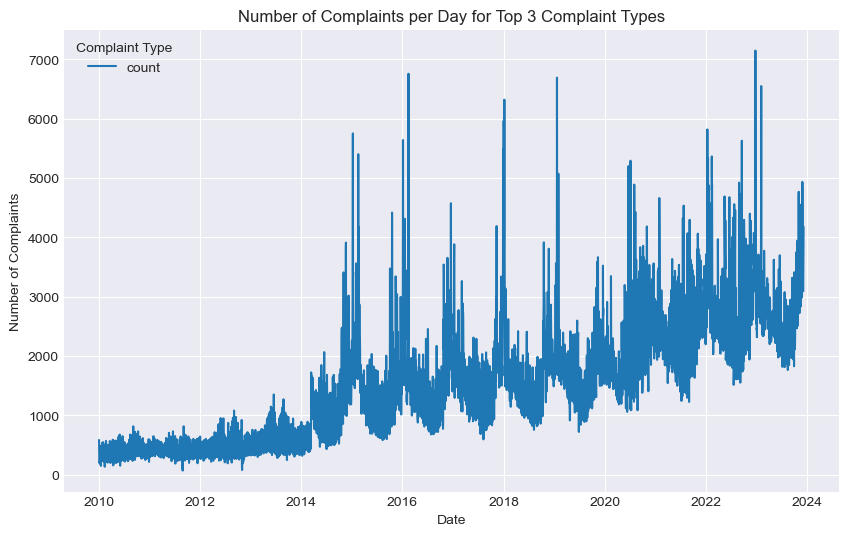

In [82]:
top_3_complaint_types(df_top3_grouped)

## Visualization 2: What are the most common complaints in the immediate area?¶

For this visualization, we create a histogram that shows the number of complaints by complaint type for the top 10 complaints in zip code 10027 from October 1st, 2018 to September 30th, 2023 (inclusive). 
As seen from the histogram, the top three complaint types are 'Noise Residential', 'Illegal Parking', and 'Heat/Hot Water'.

In [83]:
def get_data_for_visual_2() -> pd.Series:
    """Get the dataframe needed for visualization 2."""
    
    # Set time range
    start_date = pd.Timestamp('2018-10-01')
    end_date = pd.Timestamp('2023-09-30')
    # Select the data within the time range in zip code 10027 
    df_zipcode_10027 = complaint_data.loc[(complaint_data['incident_zip'] == 10027.0) &
                          (complaint_data['created_date'] >= start_date) &
                          (complaint_data['created_date'] <= end_date)]
    # Get the top 10 complaint types
    df_top10 = complaint_data['complaint_type'].value_counts().nlargest(10)
    
    return df_top10

In [84]:
df_top10 = get_data_for_visual_2()

In [85]:
# Visualization
def top_10_complaint_types_10027(df_top10: pd.Series):
    """Greate the histogram of 'Top 10 Complaint Types in Zip Code 10027'."""
    
    plt.figure(figsize=(10, 6))
    df_top10.plot(kind='bar', color='skyblue')
    
    plt.xlabel('Complaint Type')
    plt.ylabel('Frequency')
    plt.title('Top 10 Complaint Types in Zip Code 10027')
    
    plt.xticks(rotation=45)

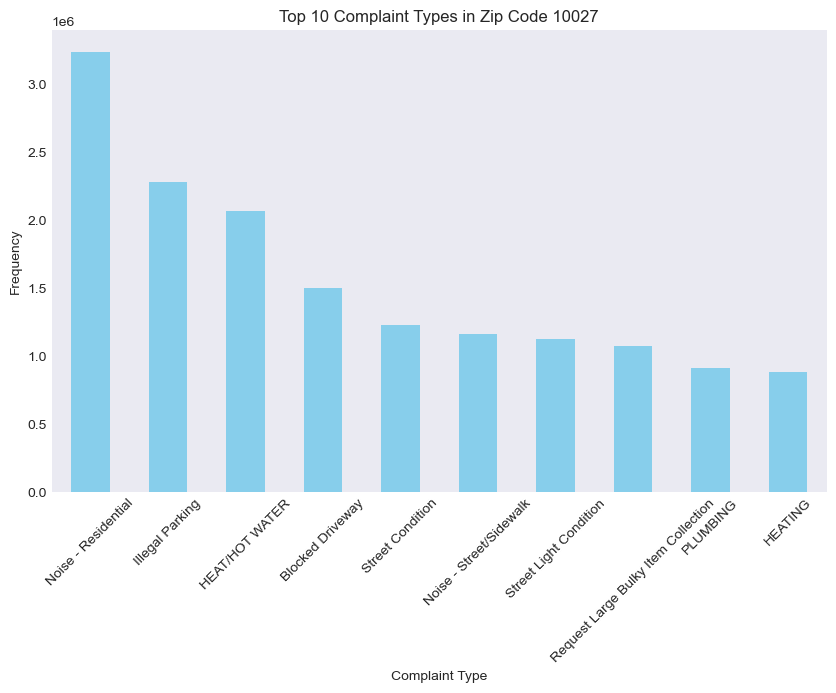

In [86]:
top_10_complaint_types_10027(df_top10)

### Extra Credit Task 1: Animation

In this animation, we visualize the number of top 10 complaint types each year from in zip code 10027 for October 1st, 2018 to September 30th, 2023 (inclusive) to better understand the change of numbers over time. In our animation below, there are total 6 frames, each frame exhibit the numbers of one year. 

In [87]:
def get_data_for_animation() -> pd.DataFrame:
    """Get the dataframe needed for animation."""
    
    top_10_types = list(df_top10.index)
    
    animation_data = complaint_data[complaint_data['complaint_type'].isin(top_10_types)]
    animation_data['year'] = animation_data['created_date'].dt.year
    animation_data = animation_data.groupby(['year', 'complaint_type']).size().reset_index(name='Frequency')
    
    return animation_data

In [88]:
animation_data = get_data_for_animation()

/Users/leticialx/anaconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [89]:
# Animation
import matplotlib.animation as animation
from IPython.display import HTML

def top_10_complaint_types_10027_animation(frames, animation_data):
    """Create frames for 'Top 10 Complainanimation_datat Types in Zip Code 10027' for each month."""
    fig, ax = plt.subplots(figsize=(10, 6))
    years = animation_data['year'].unique()
    
    def animate(frame):
        ax.clear()
        year_data = animation_data[animation_data['year'] == years[frame]]
        year_data.plot(kind='bar', x='complaint_type', y='Frequency', color='skyblue', ax=ax)
        ax.set_xlabel('Complaint Type')
        ax.set_ylabel('Frequency')
        ax.set_title(f'Top 10 Complaint Types in Zip Code 10027 (Month {frame + 1})')
        ax.tick_params(axis='x', rotation=45)
    
    ani = animation.FuncAnimation(fig, animate, frames=frames, interval=1000, blit=False)
    plt.close()
    
    return ani

# Get the number of months as the frames for the animation
frames = animation_data['year'].nunique()

# Create the animation
animation = top_10_complaint_types_10027_animation(frames, animation_data)

# Display the animation in Jupyter Notebook
HTML(animation.to_jshtml())

## Visualization 3: Is there any correlation between rent, trees, and complaints at all?

For this visualization, we create 2 subplots that share the x-axis to explore the correlation of rent, trees, and complaints between January 1st, 2015, and September 30th, 2023 (inclusive). 

Our x-axis represents the average monthly rent for each zip code area within the time frame. 
The upper plot shows the relationship between the number of trees and rent, while the lower plot shows the relationship between the number of complaints and rent. According to the graph, both the number of trees and complaints tend to decrease as rent increases. Apartments with a monthly rent of $3000-4000 dollars are appealing, with relatively fewer complaints and adequate trees.

In [92]:
def get_data_for_visual_3() -> pd.DataFrame:
    """Get the dataframe needed for visualization 3."""
    
    # Select rent data within the time range
    rent_data_filtered = rent_data[(rent_data['rent_date'] >= '2015-01-01') 
                                   & (rent_data['rent_date'] <= '2023-09-30')]
    # Match column data type
    rent_data_filtered['rent_zip'] = rent_data_filtered['rent_zip'].astype(str) 
    # Calculate average rent for each zipcode during the time frame
    rent_data_filtered = rent_data_filtered.groupby('rent_zip')['rent_amount'].mean().reset_index()
    rent_data_filtered.columns = ['rent_zip', 'average_rent']
    
    # Select the complaint data within time range
    #complaint_data['incident_zip'] = complaint_data['incident_zip'].astype('int')
    complaint_data_filtered = complaint_data[(complaint_data['created_date'] >= '2015-01-01') 
                                              & (complaint_data['created_date'] <= '2023-09-30')]
    # Group complaints and trees by zipcode
    complaint_by_zip = complaint_data_filtered.groupby('incident_zip').size().reset_index(name='num_complaints')
    
    trees_by_zip = tree_data.groupby('zipcode').size().reset_index(name='num_trees')
    # Merge filtered data frame
    merged_data_3 = rent_data_filtered.merge(trees_by_zip, left_on='rent_zip', right_on='zipcode', how='inner')
    merged_data_3 = merged_data_3.merge(complaint_by_zip, left_on='rent_zip', right_on='incident_zip', how='inner')
    
    return merged_data_3

In [93]:
merged_data_3 = get_data_for_visual_3()

In [94]:
# visualization
def rent_trees_complaints_correlation(merged_data_3: pd.DataFrame):
    """Create the 2 subplots on the correlation between rent, trees, and complaints."""
    
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))
    
    ax1.scatter(merged_data_3['average_rent'], merged_data_3['num_trees'])
    ax1.set_ylabel('Number of Trees')
    
    ax2.scatter(merged_data_3['average_rent'], merged_data_3['num_complaints'])
    ax2.set_ylabel('Number of Complaints')
    
    plt.xlabel('Rent')

In [95]:
# assign the value of 'merged_data' to a new variable, for the use of subsequent unit test
test_merged_data_3 = merged_data_3

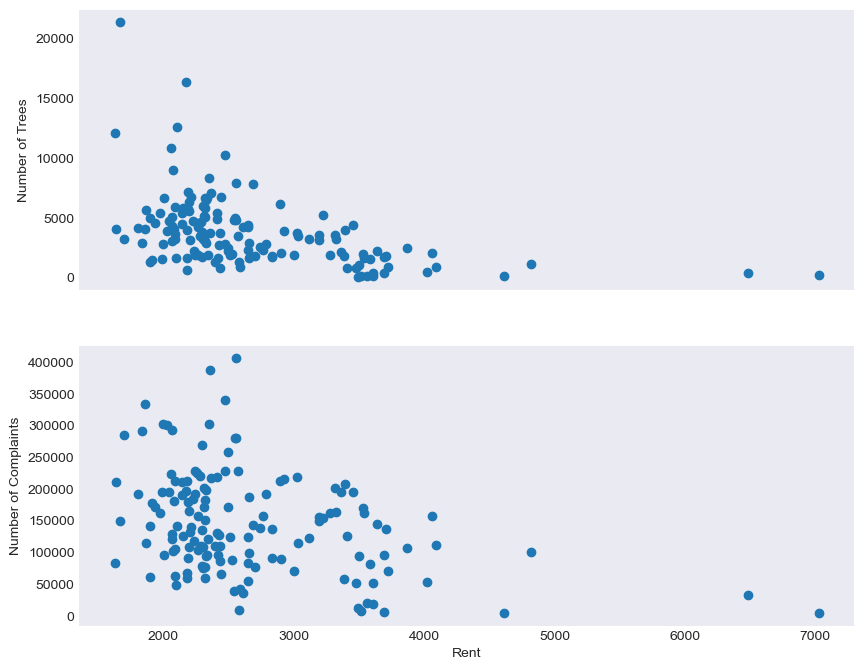

In [96]:
rent_trees_complaints_correlation(merged_data_3)

## Visualization 4: If I can afford more in rent, will there be fewer issues & complaints?

For this visualization, we use a boxplot where the x-axis is the average rent in September 2023, separated into $1000 bins, and the y-axis is the number of 311 complaints observed in each zip code between October 1, 2022 (inclusive) to September 30, 2023 (inclusive). 

According to the boxplot, most apartments fall into the bins between 2000 and 4000. Both the median point and first quantile of the average rent go up from 2000 to 3000 and go down from 3000 to 4000. Therefore, affording more in rent does not necessarily mean fewer issues & complaints.

In [105]:
def get_data_for_visual_4() -> pd.DataFrame:
    """Get the dataframe needed for visualization 4."""
    
    # Define bin ranges and labels for rent amounts
    bins = [0, 1000, 2000, 3000, 4000, np.inf]
    bin_labels = ['0-1000', '1001-2000', '2001-3000', '3001-4000', '4001+']
    
    # Match column data type
    rent_data['rent_zip'] = rent_data['rent_zip'].astype(str)
    # Select data within the time range and divide into bins
    rent_data['rent_bin'] = pd.cut(rent_data['rent_amount'], bins=bins, labels=bin_labels)
    rent_data_sept_2023 = rent_data[(rent_data['rent_date'] <= '2023-09-30')
                                    & (rent_data['rent_date'] >= '2023-09-01')]
    average_rent_by_zipcode = rent_data_sept_2023.groupby('rent_zip')['rent_amount'].mean().reset_index()
    average_rent_by_zipcode.columns = ['rent_zip', 'average_rent']
    average_rent_by_zipcode['rent_bin'] = pd.cut(average_rent_by_zipcode['average_rent'], bins=bins, labels=bin_labels)
    
    # Filter and groupby complaint data
    complaints_data_filtered = complaint_data[(complaint_data['created_date'] >= '2022-10-01') 
                                              & (complaint_data['created_date'] <= '2023-09-30')]
    complaints_by_zip = complaints_data_filtered.groupby('incident_zip').size().reset_index(name='num_complaints')
        
    # Merge data
    merged_data = rent_data_sept_2023.merge(complaints_by_zip, left_on='rent_zip', right_on='incident_zip', how='inner')
    
    return merged_data

In [106]:
merged_data_4 = get_data_for_visual_4()

In [110]:
# visulization
def rent_complaints_correlation(merged_data: pd.DataFrame):
    """Create the plot 'Boxplot of Rent vs. 311 Complaints'."""
    bin_labels = ['0-1000', '1001-2000', '2001-3000', '3001-4000', '4001+']
    
    plt.figure(figsize=(10, 6))
    plt.boxplot([merged_data[merged_data['rent_bin'] == label]['num_complaints'] for label in bin_labels], labels=bin_labels)
    plt.xlabel('Average Rent in September 2023 (Bins)')
    plt.ylabel('Number of 311 Complaints (Oct 1, 2022 - Sep 30, 2023)')
    plt.title('Boxplot of Rent vs. 311 Complaints')

In [108]:
# assign the value of 'merged_data' to a new variable, for the use of subsequent unit test
test_merged_data_4 = merged_data_4

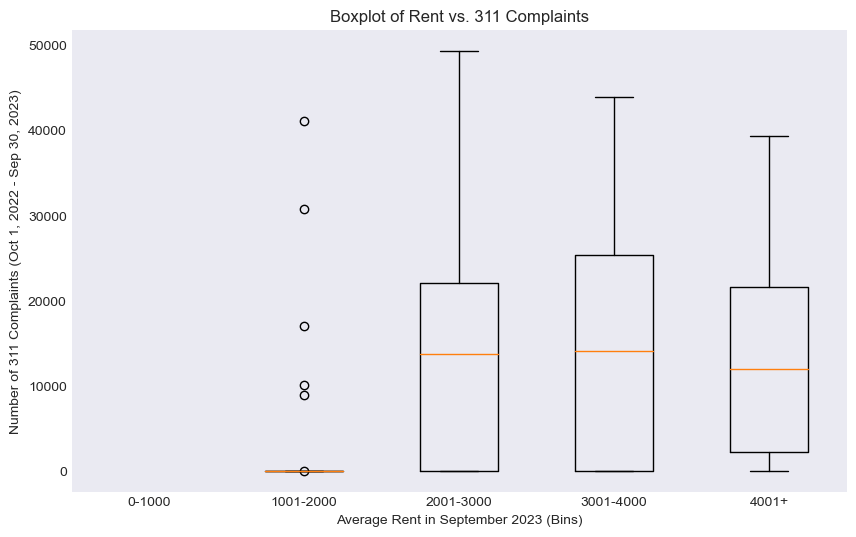

In [111]:
rent_complaints_correlation(merged_data_4)

## Visualization 5: Where were the recent 311 incidents reported from in the immediate area?

Here we create a geospatial plot of the coordinates of reported 311 incidents that happened between January 1st, 2023 and September 30th, 2023 (inclusive) within a 1 kilometer radius of (40.81, -73.96).

In [112]:
def get_data_for_visual_5() -> gpd.GeoDataFrame:
    """Get the dataframe needed for visualization 5."""
    # Select data within time range
    complaints_data_filtered = complaint_data[(complaint_data['created_date'] >= '2023-01-01') 
                                              & (complaint_data['created_date'] <= '2023-09-30')]
    
    # Create a Point geometry of the target location
    target_latitude = 40.80737875669467
    target_longitude = -73.96253174434912
    target_point = Point(target_longitude, target_latitude)
    
    # Calculate distance between incidents and the target location
    complaints_data_filtered['distance_to_target'] = complaints_data_filtered['geometry'].distance(target_point)
    
    # Filter incidents within a 1-kilometer radius of the target location
    df_incidents_within_radius = complaints_data_filtered[complaints_data_filtered['distance_to_target'] <= 1000]  # Distance in meters (1 kilometer = 1000 meters)
    
    return df_incidents_within_radius

In [113]:
df_incidents_within_radius = get_data_for_visual_5()

/var/folders/x1/12cg6y756v1bg3krkyfd6whc0000gn/T/ipykernel_60011/789024425.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  complaints_data_filtered['distance_to_target'] = complaints_data_filtered['geometry'].distance(target_point)
/Users/leticialx/anaconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [114]:
# visualization
def incidents_within_radius(df_incidents_within_radius: gpd.GeoDataFrame):
    """Create the plot '311 Incidents within 1km Radius'."""
    
    # Set latitude and longitude limits for New York City
    lat_min, lat_max = 40.5, 40.9
    lon_min, lon_max = -74.05, -73.85
    
    # Load the NYC borough boundary data
    nyc_boroughs = gpd.read_file(gpd.datasets.get_path("nybb"))
    
    # Convert NYC borough boundary data to the same CRS as df_incidents_within_radius
    nyc_boroughs = nyc_boroughs.to_crs(df_incidents_within_radius.crs)
    
    # Create a plot with the borough boundaries and incidents within NYC
    fig, ax = plt.subplots(figsize=(20, 20))
    nyc_boroughs.plot(ax=ax, alpha=0.3, edgecolor='black')
    
    df_incidents_within_radius.plot(ax=ax, markersize=0.1, color='red', marker='o', label='Incidents within 1km radius')
    
    ax.set_xlim([lon_min, lon_max])
    ax.set_ylim([lat_min, lat_max])
    
    ctx.add_basemap(ax, crs=df_incidents_within_radius.crs, source=ctx.providers.OpenStreetMap.Mapnik)
    
    ax.set_title('311 Incidents within 1km Radius in NYC')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    
    ax.legend()

/var/folders/x1/12cg6y756v1bg3krkyfd6whc0000gn/T/ipykernel_60011/436916614.py:10: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'nybb' data from the geodatasets package.

from geodatasets import get_path
path_to_file = get_path('nybb')

  nyc_boroughs = gpd.read_file(gpd.datasets.get_path("nybb"))


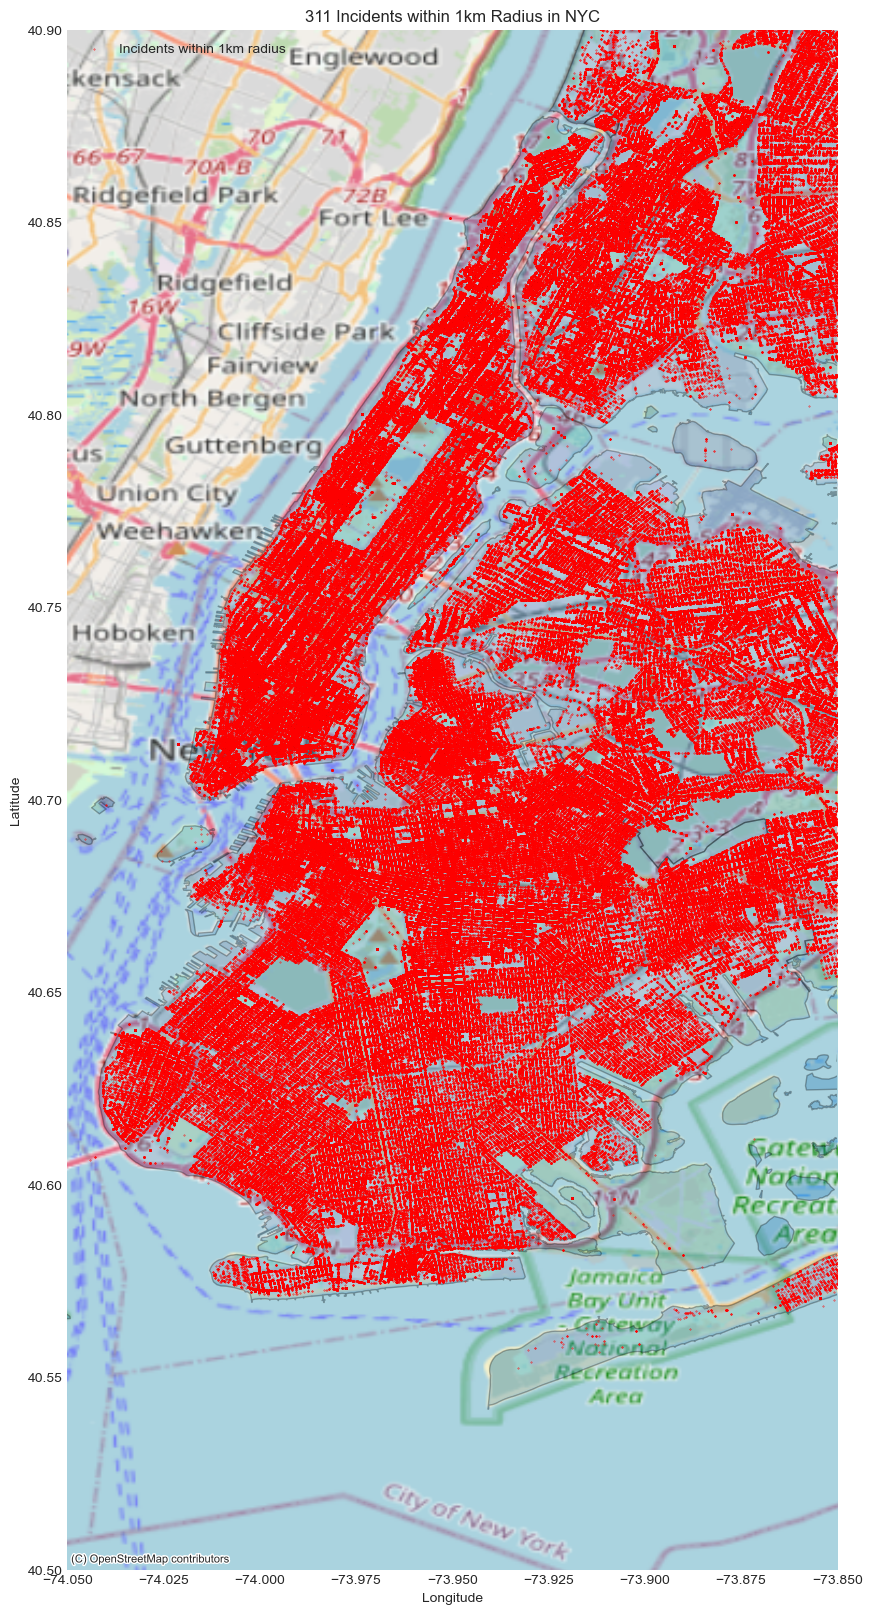

In [115]:
incidents_within_radius(df_incidents_within_radius)

## Visualization 6: Are areas trying to improve the amount of trees in the neighborhood?

For this visualization, we create a geospatial plot of two sets of data: the coordinates of trees in NYC, and the coordinates of "New Tree Request" 311 complaint types that were made from October 1st, 2018 to September 30th, 2023 (inclusive). 

According to the plot, in general, areas with more "New Tree Request" 311 complaints tend to have more trees planted, indicating that areas are already responding to the request to improve the amount of trees in the neighborhood.

In [120]:
def get_data_for_visual_6() -> gpd.GeoDataFrame:
    """Get the dataframe needed for visualization 6."""
    
    # Select "New Tree Request" complaints within the time range
    new_tree_requests = complaint_data[
        (complaint_data['complaint_type'] == 'New Tree Request') 
        & (complaint_data['created_date'] >= '2018-10-01') 
        & (complaint_data['created_date'] <= '2023-09-30')
]
    return new_tree_requests

In [121]:
def trees_and_new_trees_request(tree_data: gpd.GeoDataFrame, new_tree_requests: gpd.GeoDataFrame):
    """Create the plot 'Trees and New Tree Requests'."""
    
    # Set latitude and longitude limits for New York City
    lat_min, lat_max = 40.5, 40.9
    lon_min, lon_max = -74.05, -73.85
    
    # Load the NYC borough boundary data
    nyc_boroughs = gpd.read_file(gpd.datasets.get_path("nybb"))
    
    # Convert NYC borough boundary data to the same CRS as our data
    nyc_boroughs = nyc_boroughs.to_crs(tree_data.crs)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(20, 20))
    nyc_boroughs.plot(ax=ax, alpha=0.5, edgecolor='black')
    
    tree_data.plot(ax=ax, color='green', alpha=0.5, label='Trees', markersize=3)
    new_tree_requests.plot(ax=ax, color='blue', alpha=0.5, label='New Tree Requests', markersize=3)
    
    ax.set_xlim([lon_min, lon_max])
    ax.set_ylim([lat_min, lat_max])
    
    ctx.add_basemap(ax, crs=df_incidents_within_radius.crs, source=ctx.providers.OpenStreetMap.Mapnik)
    
    plt.title('Trees and New Tree Requests')
    plt.legend()

In [122]:
new_tree_requests = get_data_for_visual_6()

/var/folders/x1/12cg6y756v1bg3krkyfd6whc0000gn/T/ipykernel_60011/97047001.py:9: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'nybb' data from the geodatasets package.

from geodatasets import get_path
path_to_file = get_path('nybb')

  nyc_boroughs = gpd.read_file(gpd.datasets.get_path("nybb"))


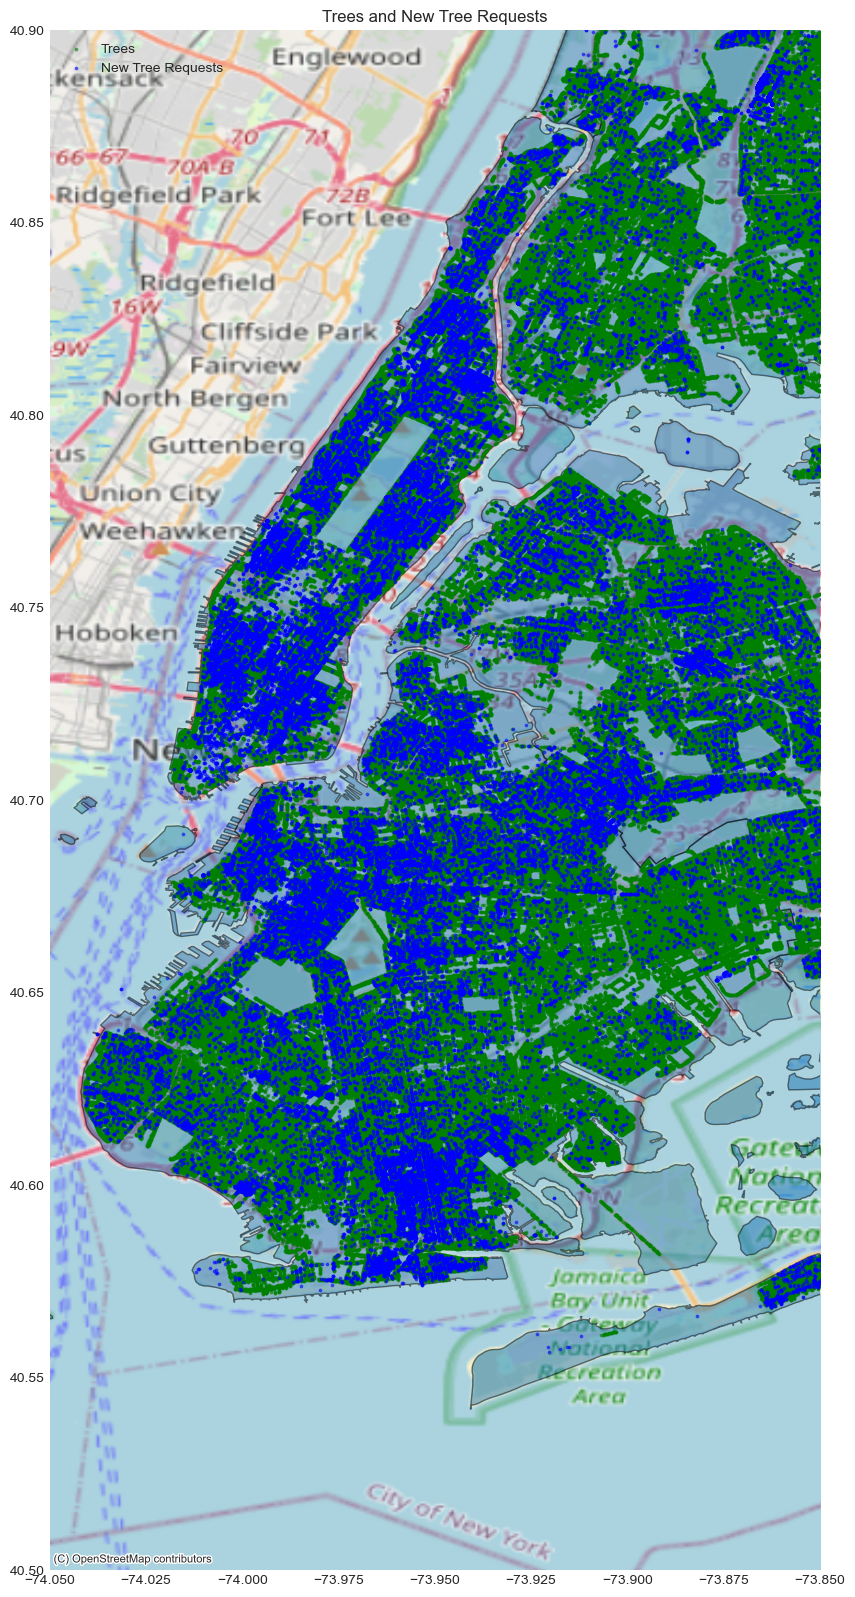

In [123]:
trees_and_new_trees_request(tree_data, new_tree_requests)

## Extra Credit-2 UnitTests

Define at least one unit test for every function and class method you’ve defined.

In [ ]:
class TestPartOne(unittest.TestCase):  
    
    def test_download_nyc_geojson_data(self) -> None:  
        
        # use the top 1000 data 
        url = "https://data.cityofnewyork.us/resource/erm2-nwe9.geojson?$$app_token=RbFfvU4T8a7C7rDHaA9eqAkvZ&$limit=1000"
        file_name = 'complaints_(1000)'
        download_nyc_geojson_data(url, file_name, force)
        expected_file = 'complaints.geojson'
        file_exists = os.path.isfile(expected_file)
        
        # assert the file was successfully downloaded
        self.assertTrue(file_exists, f"Didn't successfully download '{expected_file}'.")       

    def test_download_and_clean_311_data(self) -> None:
        
        result = download_and_clean_311_data()
        # check if the result is a GeoDataFrame
        self.assertTrue(isinstance(result, gpd.GeoDataFrame))
        
    def test_download_and_clean_tree_data(self) -> None:
        
        result = download_and_clean_tree_data()
        expected_columns = ['tree_id', 'zipcode', 'spc_common', 'health', 'status','geometry']]
        # check if all expected columns are present in the result
        for column in expected_columns:
            self.assertIn(column, result.columns)
            
    def test_load_and_clean_zipcodes(self) -> None:
        
        result = load_and_clean_zipcodes('data/zipcodes/nyc_zipcodes.shp')
        # check if the result is a GeoDataFrame
        self.assertTrue(isinstance(result, gpd.GeoDataFrame))
        
    def test_load_and_clean_zillow_data(self) -> None:
        
        result = load_and_clean_zillow_data('data/zillow_rent_data.csv')
        # check if the result is a DataFrame
        self.assertTrue(isinstance(result, pd.DataFrame))
        
    def test_load_all_data(self) -> None:
        
        # assert the data type of outputs match function result's type 
        a, b, c, d = load_all_data()
        self.assertTrue(isinstance(a, gpd.GeoDataFrame))
        self.assertTrue(isinstance(b, gpd.GeoDataFrame))
        self.assertTrue(isinstance(c, gpd.GeoDataFrame))
        self.assertTrue(isinstance(d, pd.DataFrame))

In [ ]:
class TestPartThree(unittest.TestCase):  
    
    def test_write_query_to_file(self) -> None:
        
        test_file = 'try.sql'
        write_query_to_file(
            "CREATE TABLE test_table (id INT, column_one VARCHAR(255))",
            test_file)
        
        # assert the file was successfully downloaded
        self.assertTrue(os.path.isfile(test_file), f"Did not create file '{test_file}'

In [ ]:
class TestPartFour(unittest.TestCase):
    
    def test_get_data_for_visual_1(self) -> None:
        
        # our test data
        test_dataset = pd.DataFrame({
            'created_date':['2022-09-15', '2022-10-05', '2023-05-20'],
            'complaint_type': ['Type One', 'Type Two', 'Type Three'],
            'incident_zip': [10025, 10027, 10028]
        })
        expected = pd.DataFrame({
            'created_date': ['2022-10-05', '2023-05-20'],
            'count': [1, 1]
        })
        complaint_data = test_dataset
        result = get_data_for_visual_1()
        
        # assert expected output matches function's result
        pd.testing.assert_frame_equal(result, expected)
        
    def test_top_3_complaint_types(self) -> None:
        
        # our test data
        dates = pd.date_range('2022-10-01', '2023-09-30')
        data = {'Date': dates, 'Type A': np.random.randint(0, 100, len(dates)),
                'Type B': np.random.randint(0, 100, len(dates)), 'Type C': np.random.randint(0, 100, len(dates))}
        test_dataset = pd.DataFrame(data)
        
        top_3_complaint_types(test_dataset)
        
        # assert that a plot was created
        self.assertTrue(plt.gcf())
        
    def test_get_data_for_visual_2(self) -> None:
        
        # our test data
        test_dataset = pd.DataFrame({
            'created_date':['2022-09-15', '2022-10-05', '2023-05-20'],
            'complaint_type': ['Type One', 'Type Two', 'Type Three'],
            'incident_zip': [10025, 10027, 10028]
        })
        complaint_data = test_dataset
        
        result = get_data_for_visual_2()
        
        # Assert the type of result
        self.assertIsInstance(result, pd.Series)
    
    def test_top_10_complaint_types_10027(self) -> None:
        
        top_10_complaint_types_10027(df_top10)
        
        # assert that a plot was created
        self.assertTrue(plt.gcf())

    def test_get_data_for_visual_3(self) -> None:
        
        result = get_data_for_visual_3() 
        
        # Assert the type of result
        self.assertIsInstance(result, pd.DataFrame)
        
    def test_rent_trees_complaints_correlation(self) -> None:
        
        rent_trees_complaints_correlation(merged_data_3)
        
        # assert that a plot was created
        self.assertTrue(plt.gcf())

    def test_get_data_for_visual_4(self) -> None:
        
        result = get_data_for_visual_4()
 
        # assert the type of result
        self.assertIsInstance(result, pd.DataFrame)

    def test_rent_complaints_correlation(self) -> None:
        
        rent_complaints_correlation(merged_data_4)
        
        # assert that a plot was created
        self.assertTrue(plt.gcf())

    def test_get_data_for_visual_5(self) -> None:
        
        result = get_data_for_visual_5()
        
        # assert the type of result
        self.assertIsInstance(result, gpd.GeoDataFrame)

    def test_incidents_within_radius(self) -> None:
        
        incidents_within_radius(df_incidents_within_radius)
        
        # assert that a plot was created
        self.assertTrue(plt.gcf())

    def test_get_data_for_visual_6(self) -> None:
        
        result = get_data_for_visual_6()
        
        # assert the type of result
        self.assertIsInstance(result, gpd.GeoDataFrame)

    def test_trees_and_new_trees_request(self) -> None:
        
        trees_and_new_trees_request(tree_data)
        
        # assert the type of result
        self.assertIsInstance(result, gpd.GeoDataFrame)        

In [ ]:
# get thorough examination and detailed debugging during test execution
if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], verbosity=3, exit = False)

## Extra Credit Question

In this part, we would like to explore the question: Would the number of film permits influence the number of complaints about "noise"? 

To achieve this, we take September of the year 2019 as an example to visualize the relationship between the number of film permits issued during that period and the number of complaints about noise by zip code. Our graph indicates that when numbers are small, an increase in permits tends to be positively correlated with the number of complaints about noise, but the relationship is not that significant as the number of permits becomes larger than 4.

In [124]:
query5 = 'SELECT * FROM permits'

# Read all data into pandas DataFrame and geopandas GeoDataFrame
permit_data = pd.read_sql(query5, engine)

In [125]:
# Select events happened during 2023-09
permit_data_exploded = permit_data.assign(zipcode_s=permit_data['zipcode_s'].str.split(',')).explode('zipcode_s')
permit_data_filtered = permit_data_exploded[((permit_data_exploded['start_date'] <= '2023-09-01') 
                                                     & (permit_data_exploded['end_date'] >= '2023-09-01'))
                                                     | ((permit_data_exploded['start_date'] >= '2023-09-01')
                                                     & (permit_data_exploded['start_date'] <= '2023-09-30'))]
permit_data_filtered = permit_data_filtered.groupby('zipcode_s').size().reset_index(name='num_permits')

In [127]:
complaint_data['created_date'] = pd.to_datetime(complaint_data['created_date'])
complaints_filtered = complaint_data[(complaint_data['created_date'] >= '2023-12-01')
                                    & (complaint_data['created_date'] <= '2023-12-30')] 
complaints_filtered = complaints_filtered[complaints_filtered['complaint_type'].str.contains('Noise')]
complaints_filtered = complaints_filtered.groupby('incident_zip').size().reset_index(name='num_complaints')

In [128]:
merged_data_extra4 = permit_data_filtered.merge(complaints_filtered, left_on='zipcode_s', right_on='incident_zip', how='inner')

In [129]:
def extra_credit(merged_data_extra4: pd.DataFrame):
    """Create the plot 'Scatter plot of Number of Permits vs Number of Complaints'."""
    
    plt.figure(figsize=(8, 6))
    plt.scatter(merged_data_extra4['num_permits'], merged_data_extra4['num_complaints'], alpha=0.5)  # 'df' 是你的 DataFrame，'x' 和 'y' 是两个列名
    plt.xlabel('Number of Permits')
    plt.ylabel('Number of Complaints')
    plt.title('Scatter plot of Number of Permits vs Number of Complaints')
    plt.grid(True)

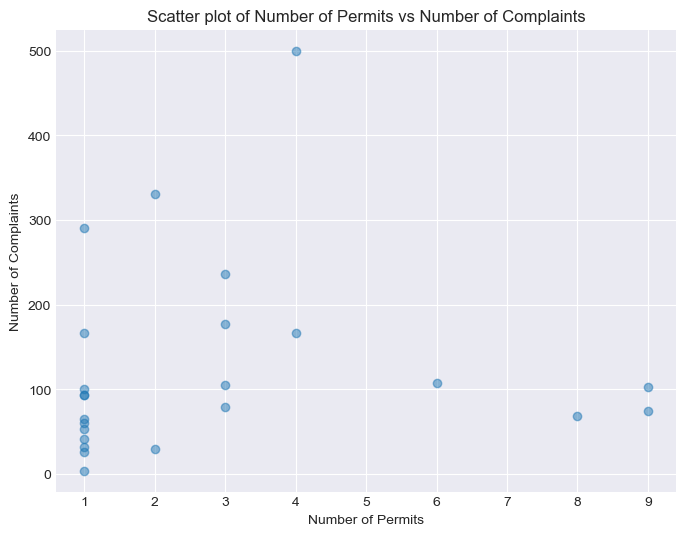

In [130]:
extra_credit(merged_data_extra4)